<a href="https://colab.research.google.com/github/chaalp/repo/blob/master/DataVisualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px

In [ ]:
# Load chartevents data
d1 = files.upload()
chartevents = pd.read_csv('CHARTEVENTS.csv', low_memory=False)

# Convert 'value' column to numeric (coerce errors to NaN if conversion fails)
chartevents['value'] = pd.to_numeric(chartevents['value'], errors='coerce')

Saving CHARTEVENTS.csv to CHARTEVENTS.csv


In [ ]:
# Load d_items data
d2 = files.upload()
d_items = pd.read_csv('D_ITEMS.csv')

Saving D_ITEMS.csv to D_ITEMS.csv


In [ ]:
# Load procedureevents_mv data
d3 = files.upload()
procedureevents_mv = pd.read_csv('PROCEDUREEVENTS_MV.csv')

Saving PROCEDUREEVENTS_MV.csv to PROCEDUREEVENTS_MV (3).csv


In [ ]:
# Load d_labitems data
d4 = files.upload()
d_labitems = pd.read_csv('D_LABITEMS.csv')

Saving D_LABITEMS.csv to D_LABITEMS.csv


In [ ]:
# Load labevents data
d5 = files.upload()
labevents = pd.read_csv('LABEVENTS.csv')

Saving LABEVENTS.csv to LABEVENTS.csv


## Top Vital Signs Over Time for Subject

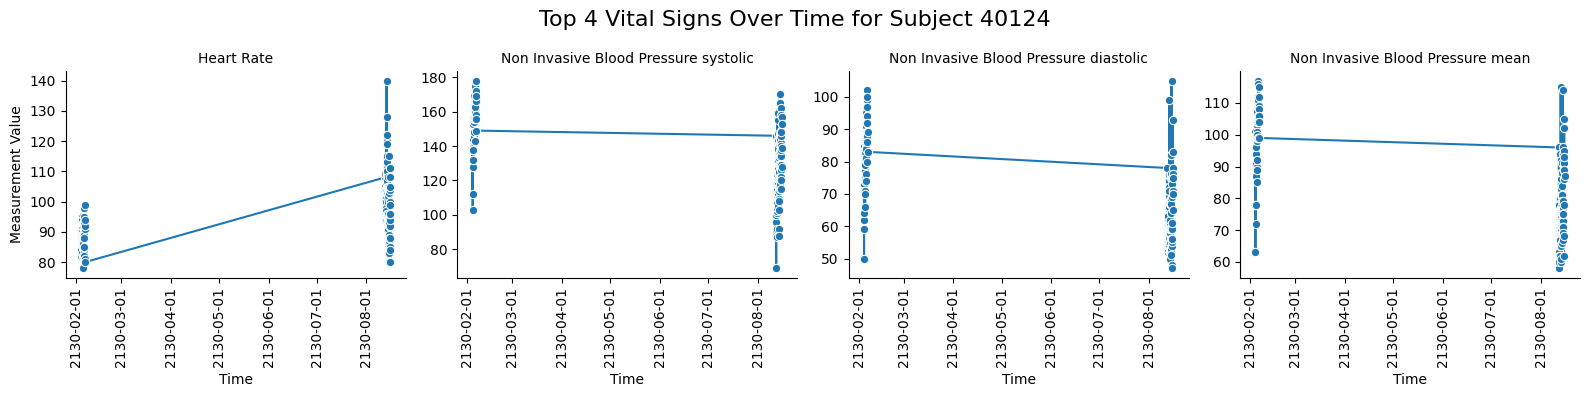

In [ ]:
# Define subject_id
subject_id = 40124  # Replace with the subject_id you want

# Merge chartevents with d_items to get the labels for each itemid
merged_data = pd.merge(chartevents, d_items[['itemid', 'label']], on='itemid', how='inner')

# Filter data for the specific subject_id
subject_data = merged_data[merged_data['subject_id'] == subject_id].copy()  # Use .copy() to avoid SettingWithCopyWarning

# Ensure 'charttime' is in datetime format
subject_data.loc[:, 'charttime'] = pd.to_datetime(subject_data['charttime'], errors='coerce')

# Count occurrences of non-null values for each label (without using apply)
label_counts = subject_data.groupby('label')['charttime'].apply(lambda x: x.notna().sum()).reset_index(name='count')

# Sort labels by count and select the top 4
top_labels = label_counts.sort_values(by='count', ascending=False).head(4)['label']

# Filter the subject_data to include only rows for the top 4 labels
top_subject_data = subject_data[subject_data['label'].isin(top_labels)]

# Check for missing values
missing_values = top_subject_data[['charttime', 'valuenum']].isna().sum()

# Set up a FacetGrid with 'label' as the column
g = sns.FacetGrid(top_subject_data, col="label", col_wrap=4, height=4, sharex=True, sharey=False)

# Plot each vital sign in the facet grid
g.map(sns.lineplot, "charttime", "valuenum", marker='o')

# Customize the plot
g.set_axis_labels('Time', 'Measurement Value')
g.set_titles("{col_name}")
g.fig.suptitle(f'Top 4 Vital Signs Over Time for Subject {subject_id}', fontsize=16)

# Rotate the x-axis labels to make them vertical
g.set_xticklabels(rotation=90)

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

## Procedure/Event Frequencies Over Time

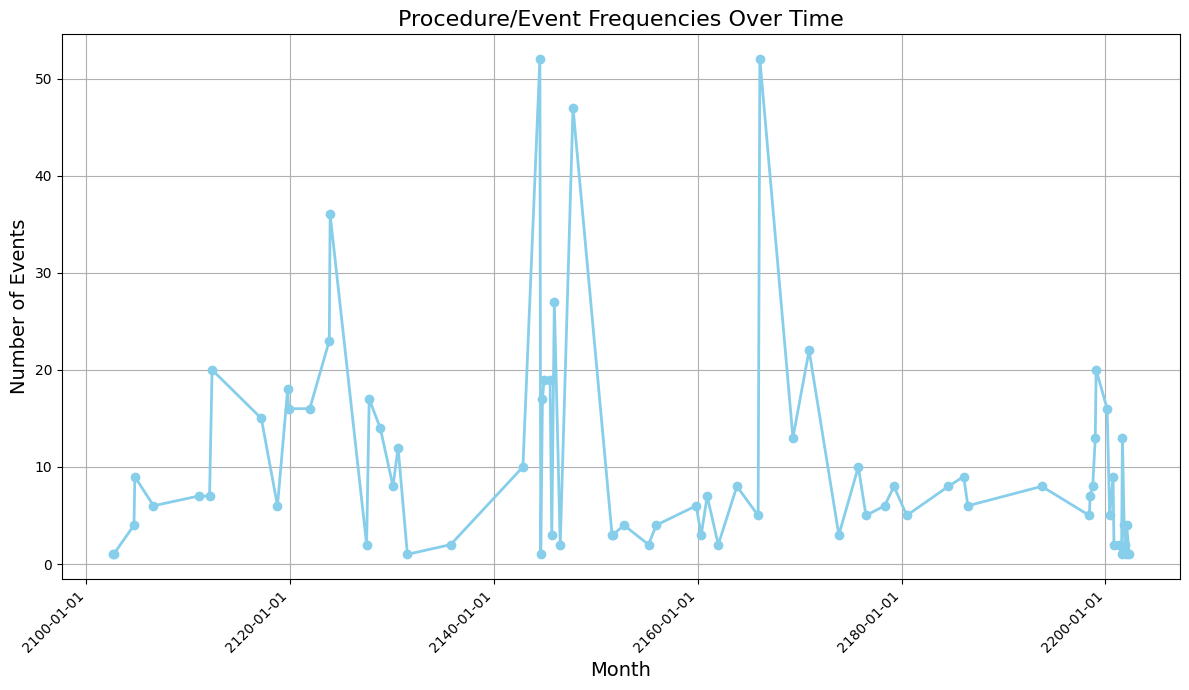

In [ ]:
# Ensure 'starttime' is a datetime column
procedureevents_mv['starttime'] = pd.to_datetime(procedureevents_mv['starttime'], errors='coerce')

# Extract year-month from the start time (converted to the first day of each month)
procedureevents_mv['month'] = procedureevents_mv['starttime'].dt.to_period('M').dt.to_timestamp()

# Count the frequency of procedures per month
event_counts = procedureevents_mv.groupby('month').size()

# Plotting the number of events per month
plt.figure(figsize=(12, 7))
event_counts.plot(kind='line', marker='o', color='skyblue', lw=2)

# Customizing plot
plt.title('Procedure/Event Frequencies Over Time', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Number of Events', fontsize=14)
plt.grid(True)

# Formatting the x-axis to show the date in a readable format
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels and align them to the right
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))  # Custom format

# Show the plot
plt.tight_layout()  # Adjust layout for better fit
plt.show()

## Heart Rate Over Time for All Patients

In [ ]:
# Filter the 'vital_signs' list
vital_signs = ['Heart Rate']

# Get itemids corresponding to the vital signs
vital_signs_ids = d_items[d_items['label'].isin(vital_signs)][['itemid', 'label']]

# Merge with chartevents to get the data for the vital signs
vital_signs_data = pd.merge(chartevents, vital_signs_ids, on='itemid', how='inner')

# Ensure charttime is in datetime format
vital_signs_data['charttime'] = pd.to_datetime(vital_signs_data['charttime'], errors='coerce')

# Set 'charttime' as a column (not index) to ensure seaborn handles it correctly
vital_signs_data.reset_index(inplace=True)

# Filter normal and abnormal heart rate values
normal_range_min = 60  # bpm
normal_range_max = 100  # bpm

normal_heart_rate_data = vital_signs_data[(vital_signs_data['value'] >= normal_range_min) &
                                           (vital_signs_data['value'] <= normal_range_max)].copy()  # Use .copy()
abnormal_heart_rate_data = vital_signs_data[(vital_signs_data['value'] < normal_range_min) |
                                             (vital_signs_data['value'] > normal_range_max)].copy()  # Use .copy()

# Add 'Type' column safely using .loc
normal_heart_rate_data.loc[:, 'Type'] = 'Normal'
abnormal_heart_rate_data.loc[:, 'Type'] = 'Abnormal'

# Combine the two DataFrames
combined_data = pd.concat([normal_heart_rate_data, abnormal_heart_rate_data])

# Define the color palette for abnormal heart rates (unique colors for each subject)
palette = sns.color_palette("tab20", n_colors=combined_data['subject_id'].nunique())
subject_to_color = {subject_id: palette[i] for i, subject_id in enumerate(combined_data['subject_id'].unique())}

# Map color for each subject
combined_data['color'] = combined_data['subject_id'].map(subject_to_color)

# Create an interactive plot using Plotly
fig = px.scatter(combined_data,
                 x='charttime',
                 y='value',
                 color='color',
                 title='Heart Rate Over Time: Normal vs Abnormal for All Patients',
                 labels={'value': 'Heart Rate (bpm)', 'charttime': 'Date', 'subject_id': 'Subject ID', 'Type': 'Heart Rate Type'},
                 hover_data={'subject_id': True, 'value': True, 'charttime': True, 'Type': True},
                 color_continuous_scale='Viridis')

# Remove the color legend and set layout properties
fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Heart Rate (bpm)',
    xaxis_tickformat='%Y-%m-%d',
    title='Heart Rate Over Time: Normal vs Abnormal for All Patients',
    showlegend=False,
    plot_bgcolor='white',
    paper_bgcolor='white',
    xaxis=dict(
        tickangle=45,  # Rotate x-axis labels by 45 degrees
        side='right'
    ),
    font=dict(size=12),  # Font size for better readability
)

# Show the plot
fig.show()


## Distribution of Procedure/Event Durations

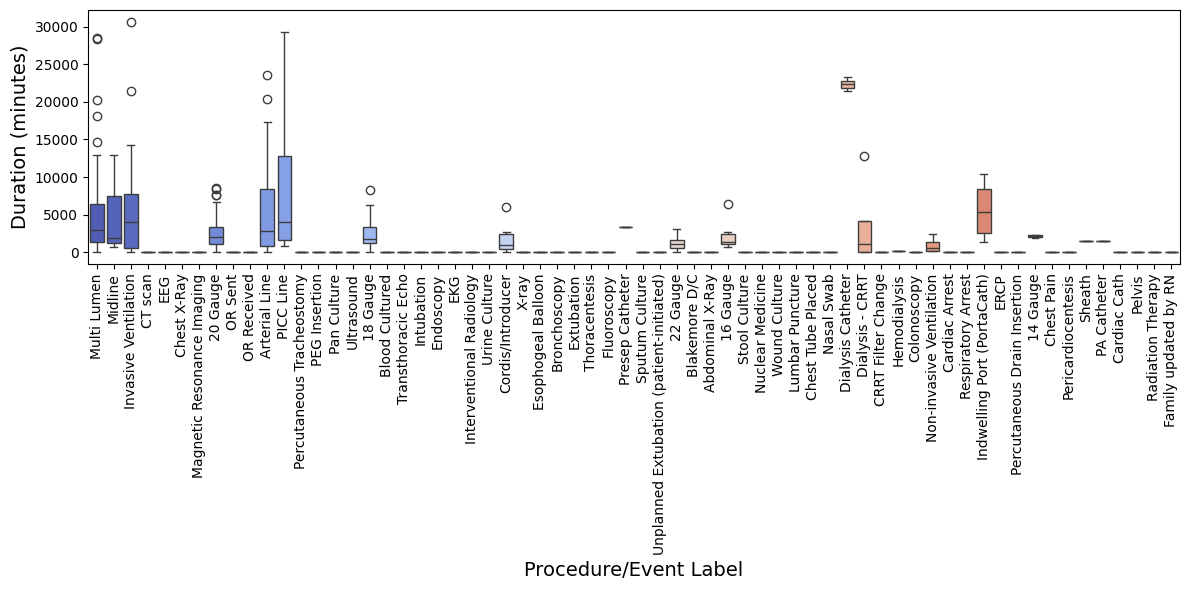

In [ ]:
# Merge the two dataframes on itemid
merged_df = pd.merge(procedureevents_mv, d_items[['itemid', 'label']], on='itemid', how='left')

merged_df['starttime'] = pd.to_datetime(merged_df['starttime'])
merged_df['endtime'] = pd.to_datetime(merged_df['endtime'])

# Calculate the duration
merged_df['duration'] = (merged_df['endtime'] - merged_df['starttime']).dt.total_seconds() / 60  # Duration in minutes

# Plot the boxplot with the correct usage of 'hue'
plt.figure(figsize=(12, 6))
sns.boxplot(x='label', y='duration', data=merged_df, hue='label', palette='coolwarm', legend=False)

# Customize the plot
plt.xticks(rotation=90)  # Rotate labels for readability
plt.xlabel('Procedure/Event Label', fontsize=14)
plt.ylabel('Duration (minutes)', fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

##Top 100 Most Frequent Lab Tests

In [ ]:
# Merge datasets on 'itemid'
merged_data = pd.merge(labevents, d_labitems, on='itemid', how='inner')

# Drop NaN values in 'label' to avoid issues with empty labels
merged_data = merged_data.dropna(subset=['label'])

# Get top 100 most frequent lab test labels
top_100_labels = merged_data['label'].str.title().value_counts().head(100)

# Create a DataFrame for Plotly
plot_data = pd.DataFrame({
    'Lab Test Label': top_100_labels.index,
    'Frequency': top_100_labels.values
})

# Extract the 'viridis' palette from Seaborn
viridis_palette = sns.color_palette("viridis", len(top_100_labels)).as_hex()

# Create an interactive bar plot with Plotly
fig = px.bar(plot_data,
             x='Lab Test Label',
             y='Frequency',
             title='Top 100 Most Frequent Lab Test Labels',
             labels={'Lab Test Label': 'Lab Test Label', 'Frequency': 'Frequency'},
             hover_data={'Lab Test Label': True, 'Frequency': True},
             color=plot_data.index,  # Color by index to apply the 'viridis' palette
             color_continuous_scale=viridis_palette)  # Apply 'viridis' color scale

# Customize layout for better readability
fig.update_layout(
    xaxis_title='Lab Test Label',
    yaxis_title='Frequency',
    xaxis_tickangle=90,  # Rotate x-axis labels for readability
    font=dict(size=12),
    title_font_size=14,
    xaxis_tickfont_size=8,
    plot_bgcolor='white',
    paper_bgcolor='white',
    showlegend=False
)

# Show the plot
fig.show()